# Simulating levels of overfitting in polynomial models

This notebook develops an experiment to study the behavior of polynomial models (curves) of different levels of complexity used to fit data.

## Method

* The data to be fitted is a linear combination of [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) from order 0 up to 20

* The data is sampled and those are fitted by two less complex models (polynomials of 10th and 2nd order)
    * Each sample is caracterized by its `size` $N$ and `noise` $\sigma$ modeled as $\text{~} Gauss(0,\sigma)$
    * For fixed properties `size` and `noise` many samples are taken and separately fitted by both polynomial models

* The experiment runs for many combinations o sample properties. Each run equivalent to one combination $(N, \sigma^2)$
    * Each run has `rounds` and at each round one random sample is fitted by both polynomial models
    * After one entire run, the fitting polynomials are stored in batches. One batch separately for 10th and 2nd order polynomials

* Based on the batches and the target (legendre polynomial) the *expected generalization error* is computed for both models and their *difference* is stored
    * *exptected generalization error* is computed based on the *bias-variance* tradeoff

## Result

The procedure returns a grid as an 2d-ndarray where each gridpoint corresponds to one pair $(N, \sigma^2)$ storing the difference between the *errors* of the models selected for this experiment, 10th and 2nd order polynomials.



In [1]:
# initializatoin cell
import numpy as np
import pickle
import resources.functk as ftk
from resources.plot import heatmap
from resources.polynomials import Legendre_polynomial, Fit_polynomial

### 1. Constructing the TARGET

The target is polynomial $f(x)$ set as a linear combination of Legendre polynomials, each valid within the domain $[-1, 1]$.

The `domain_points` variable is a dicretization parameters for target's domain and `q_target` represents the *complexity* of the target as the highest power used in the polynomial.

In [2]:
def generate_target(Qf, x, seed=None):
    """a function to generate a linear combination fo legendre pols. up to Qf order"""
    alphas = generate_coeff(Qf, seed)
    ps = [Legendre_polynomial(q) for q in range(1,Qf+1)]
    return np.dot(np.concatenate([poly(x).reshape(-1,1) for poly in ps], axis=1), alphas)

def generate_coeff(n, seed=None):
    np.random.seed(seed)
    return np.random.rand(n)

In [3]:
seed = 987654321
domain_points = 250
q_target = 20
xs = np.linspace(-1, 1, domain_points)
target = generate_target(q_target, xs, seed=seed)

# data to be used throughtout the notebook
data = tuple(zip(xs, target))
np.save('data', np.array(data))

### 2. Fitting BATCHES

A batch is a collection of same order polynomials fitted on particular samples from **target**.

The number of batches reflects the number of different order of polynomials referred on `order_list` argument. Other important arguments are
* `data` - The data from where samples will be drawn
* `rounds` - The number of samples to be drawn from `data`
* `lamb` - optitional regularization factor
* `params` - A map for the sample size `N` and the `noise` variance $\sigma^2$

The function `make_batch` is *curried* with the parameters fixed for this experiment, so it only need `params` as *input* and returns as output the specified batches.

In [4]:
def get_sample(data, size, seed=None):
    """extract a random sample of *size* from *data*"""
    np.random.seed(seed)
    x, y = zip(*data)
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    indices = indices[:int(size)]
    return np.array(x)[indices], np.array(y)[indices]

def add_noise(arr, noise_lvl):
    np.random.seed()
    return arr + np.random.normal(0, math.sqrt(noise_lvl), size=arr.shape)

def make_batch(order_list, params, data, rounds, lamb=0, seed=None):
    """make a batch of fitting curves for each model specified in *order_list* on *rounds*"""
    N = params['N']
    noise_lvl = params['noise']
        
    batch = []
    for _ in range(rounds):
        sample_x, sample_y = get_sample(data, N, seed)
        sample_y = add_noise(sample_y, noise_lvl)
        fittings = []
        for order in order_list:
            fn = Fit_Polynomial(order).fit(zip(sample_x, sample_y))
            fittings.append(fn)
        batch.append(fittings)
    return zip(*batch)

In [5]:
orderlst = [2, 10]
rounds = 50

# currying make_batch for future use
spc_batch = ftk.curry(make_batch)
spc_batch = spc_batch(orderlst, data=data, rounds=rounds)

### 3. Computing GENERALIZATION ERRORS

The expected generalization error is computed from *bias* and *variation* for each batch. It works basicly as *reduce* operation as each batch leads to a singla number $\mathbb{E}_{out}[error]$

The function `compare_errors` is curried in order to receive as *input* the batches from the previous stage and return the difference of the error between the 10th and 2nd order polynomials.

These two steps in the process are put together by `composition` into one single pipeline which receive in one end the parameters $(N, \sigma^2)$ and returns at the other end the subtracted errors

In [6]:
def compute_batch(batch, xs):
    return np.concatenate([(g(xs)).reshape(1,-1) for g in batch], axis=0)

def E_out(batch, data):
    """Take a batch of polynomial curves and compute generalization error as in
    E[E_out] = E[var(x) + bias(x)]"""
    xs, target = zip(*data)
    values = compute_batch(batch, xs)
    g_bar = np.mean(values, axis=0)
    g_var = np.var(values, axis=0)
    return  g_var.mean() + np.mean((g_bar - np.array(target))**2)

def compare_errors(batches, data):
    g1, g2 = batches
    return E_out(g2, data) - E_out(g1, data)

In [7]:
# currying error comparison function
errors = ftk.curry(compare_errors)
errors_on_target = errors(data=data)

# arranging the functions in a pipeline
pipeline = ftk.compose(errors_on_target, spc_batch)

### 4. Setting up grid of pairs $(N, \sigma^2)$

In [8]:
def dump_data(result, filename):
    pickle.dump(result, open(filename+'.pkl', 'wb'))

# simulation parameters
id_='01'
max_size = 150
noise_max = 2
noise_intervals = 120
fname = f'sim{id_}x{rounds}_data-{q_target}-{orderlst[0]}-{orderlst[1]}_n{domain_points}_{noise_max}-{noise_intervals}_{max_size}'

# setting grid up
noise_lvls, N_sizes = np.mgrid[.1:noise_max:noise_intervals *1j, 10:max_size+1]

# running simulation on grid points
batch_params = map(lambda x: {'N':x[0], 'noise':x[1]}, zip(N_sizes.ravel(), noise_lvls.ravel()))
out = list(map(pipeline, batch_params))
out = np.array(out).reshape(N_sizes.shape)

dump_data(out, fname)
np.save('noise_std', noise_lvls)
np.save('n_sizes', N_sizes)

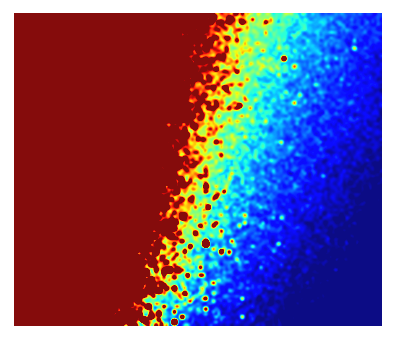

In [9]:
# plotting example
sim = pickle.load(open(fname+'.pkl', 'rb'))
fig = heatmap(sim,{}, c_range=(-.2, .2))